In [5]:
import cv2
import face_recognition
import pickle
import os
# Importing student images
folderPath = 'images'
pathList = os.listdir(folderPath)
print(pathList)
imgList = []
studentIds = []
for path in pathList:
    imgList.append(cv2.imread(os.path.join(folderPath, path)))
    studentIds.append(os.path.splitext(path)[0])
 
print(studentIds)    
def findEncodings(imagesList):
    encodeList = []
    for img in imagesList:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        encode = face_recognition.face_encodings(img)[0]
        encodeList.append(encode)
 
    return encodeList
 
print("Encoding Started ...")
encodeListKnown = findEncodings(imgList)
encodeListKnownWithIds = [encodeListKnown, studentIds]
print("Encoding Complete")
 
file = open("EncodeFile.p", 'wb')
pickle.dump(encodeListKnownWithIds, file)
file.close()
print("File Saved")
    
    

['3457.jpeg', '4356.jpeg']
['3457', '4356']
Encoding Started ...
Encoding Complete
File Saved


In [6]:
import cv2
import pickle
import mediapipe as mp
import face_recognition

# Load MediaPipe Face Detection model
mp_face_detection = mp.solutions.face_detection

# Initialize VideoCapture
cap = cv2.VideoCapture(0)

# Load known face encodings and IDs
print("Loading encode file ...")
file = open('EncodeFile.p', 'rb')
encodeListKnownWithIds = pickle.load(file)
file.close()
encodeListKnown, studentIds = encodeListKnownWithIds
print("Encode file loaded")

while True:
    ret, frame = cap.read()

    if not ret:
        break

    # Convert the image from BGR to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame for face detection using MediaPipe
    with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detection:
        results = face_detection.process(rgb_frame)

        if results.detections:
            for detection in results.detections:
                # Get the bounding box coordinates of the detected face
                bbox = detection.location_data.relative_bounding_box
                h, w, c = frame.shape
                xmin = int(bbox.xmin * w)
                ymin = int(bbox.ymin * h)
                width = int(bbox.width * w)
                height = int(bbox.height * h)
                xmax = xmin + width
                ymax = ymin + height

                # Crop the face region from the frame
                face_image = frame[ymin:ymax, xmin:xmax]

                # Convert the face image to RGB and resize it
                face_image_rgb = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
                face_image_rgb = cv2.resize(face_image_rgb, (0, 0), fx=0.25, fy=0.25)

                # Encode the face image using face_recognition library
                face_encodings = face_recognition.face_encodings(face_image_rgb)

                if len(face_encodings) > 0:
                    face_encoding = face_encodings[0]

                    # Compare the face encoding with known face encodings
                    matches = face_recognition.compare_faces(encodeListKnown, face_encoding)
                    name = "Unknown"

                    if True in matches:
                        # Find the best match
                        match_index = matches.index(True)
                        name = studentIds[match_index]

                    # Draw the bounding box and label on the frame
                    cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
                    cv2.putText(frame, name, (xmin, ymin - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Face Recognition', frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the VideoCapture and close all windows
cap.release()
cv2.destroyAllWindows()

Loading encode file ...
Encode file loaded


Loading encode file ...
Encode file loaded


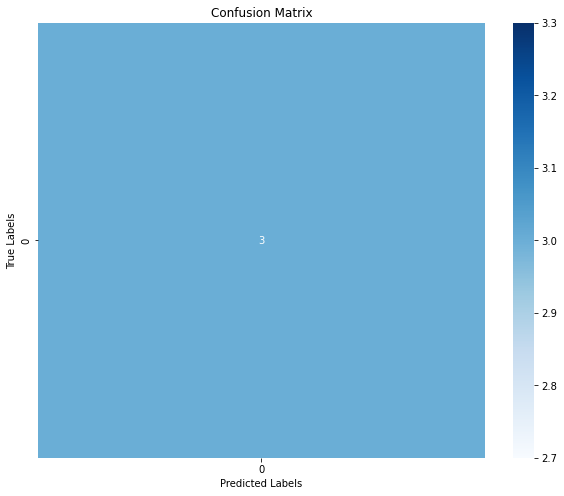

Classification Report:
              precision    recall  f1-score   support

        4356       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



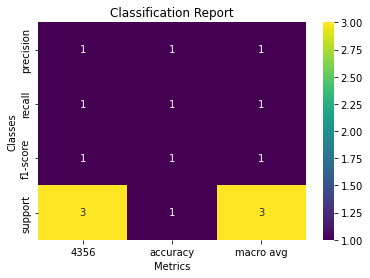

In [5]:
import cv2
import pandas as pd
import pickle
import mediapipe as mp
import face_recognition
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load MediaPipe Face Detection model
mp_face_detection = mp.solutions.face_detection

# Initialize VideoCapture
cap = cv2.VideoCapture(0)

# Load known face encodings and IDs
print("Loading encode file ...")
file = open('EncodeFile.p', 'rb')
encodeListKnownWithIds = pickle.load(file)
file.close()
encodeListKnown, studentIds = encodeListKnownWithIds
print("Encode file loaded")

# Initialize lists for true labels and predicted labels
true_labels = []
predicted_labels = []

while True:
    ret, frame = cap.read()

    if not ret:
        break

    # Convert the image from BGR to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame for face detection using MediaPipe
    with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detection:
        results = face_detection.process(rgb_frame)

        if results.detections:
            for detection in results.detections:
                # Get the bounding box coordinates of the detected face
                bbox = detection.location_data.relative_bounding_box
                h, w, c = frame.shape
                xmin = int(bbox.xmin * w)
                ymin = int(bbox.ymin * h)
                width = int(bbox.width * w)
                height = int(bbox.height * h)
                xmax = xmin + width
                ymax = ymin + height

                # Crop the face region from the frame
                face_image = frame[ymin:ymax, xmin:xmax]

                # Convert the face image to RGB and resize it
                face_image_rgb = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
                face_image_rgb = cv2.resize(face_image_rgb, (0, 0), fx=0.25, fy=0.25)

                # Encode the face image using face_recognition library
                face_encodings = face_recognition.face_encodings(face_image_rgb)

                if len(face_encodings) > 0:
                    face_encoding = face_encodings[0]

                    # Compare the face encoding with known face encodings
                    matches = face_recognition.compare_faces(encodeListKnown, face_encoding)
                    name = "Unknown"

                    if True in matches:
                        # Find the best match
                        match_index = matches.index(True)
                        name = studentIds[match_index]

                    # Append true and predicted labels to the respective lists
                    true_labels.append(name)
                    predicted_labels.append(name)

                    # Draw the bounding box and label on the frame
                    cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
                    cv2.putText(frame, name, (xmin, ymin - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Face Recognition', frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the VideoCapture and close all windows
cap.release()
cv2.destroyAllWindows()

# Calculate and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Calculate and print classification report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)
# Plot classification report
report_data = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()
plt.figure(figsize=(6, 4))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="viridis")
plt.xlabel("Metrics")

plt.ylabel("Classes")
plt.title("Classification Report")
plt.show()